In [42]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier #(for featrure importance)

plt.rcParams["figure.figsize"] = (12,6)
sns.set_style("whitegrid")

In [43]:
# data loading
df = pd.read_csv("btc_1h_data_2018_to_2025.csv")

df.head()

df.info()
df.describe()
print("Shape: ", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70823 entries, 0 to 70822
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open time                     70822 non-null  object 
 1   Open                          70823 non-null  float64
 2   High                          70823 non-null  float64
 3   Low                           70823 non-null  float64
 4   Close                         70823 non-null  float64
 5   Volume                        70823 non-null  float64
 6   Close time                    70822 non-null  object 
 7   Quote asset volume            70823 non-null  float64
 8   Number of trades              70823 non-null  int64  
 9   Taker buy base asset volume   70823 non-null  float64
 10  Taker buy quote asset volume  70823 non-null  float64
 11  Ignore                        70823 non-null  int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 6.5+ MB
Sha

In [44]:
df.columns

Index(['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
       'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'Ignore'],
      dtype='object')

In [45]:
#valiation check for datatime 
df['Open time'] = pd.to_datetime(df['Open time'])
df = df.sort_values('Open time').copy()
print("Date range: ", df['Open time'].min(), " to ", df['Open time'].max())

Date range:  2018-01-01 00:00:00  to  2026-02-03 21:00:00


In [46]:
# Remove missing price or volume
df = df.dropna(subset=['Open','High','Low','Close','Volume'])

# Remove duplicate hours
df = df.drop_duplicates()

# Remove invalid price rows
df = df[df['High'] >= df['Low']]

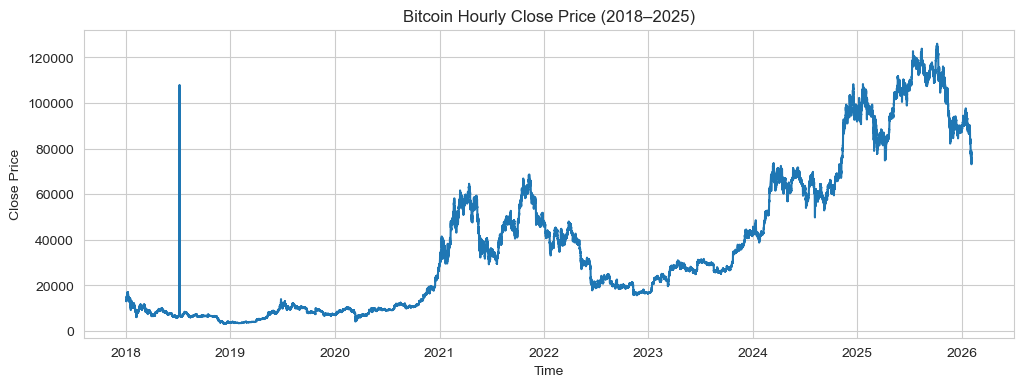

In [47]:
# Time series price behaviour

plt.figure(figsize=(12,4))
plt.plot(df['Open time'], df['Close'])
plt.title("Bitcoin Hourly Close Price (2018–2025)")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

In [ ]:
# Price Chaging Distribution

df['price_range'] = df['High'] - df['Low']
df['body_size'] = abs(df['Close'] - df['Open'])
df['return'] = (df['Close'] - df['Open']) / df['Open']
df['log_return'] = np.log(df['Close'] / df['Open'])
df[['price_range', 'body_size', 'return', 'log_return']].describe()

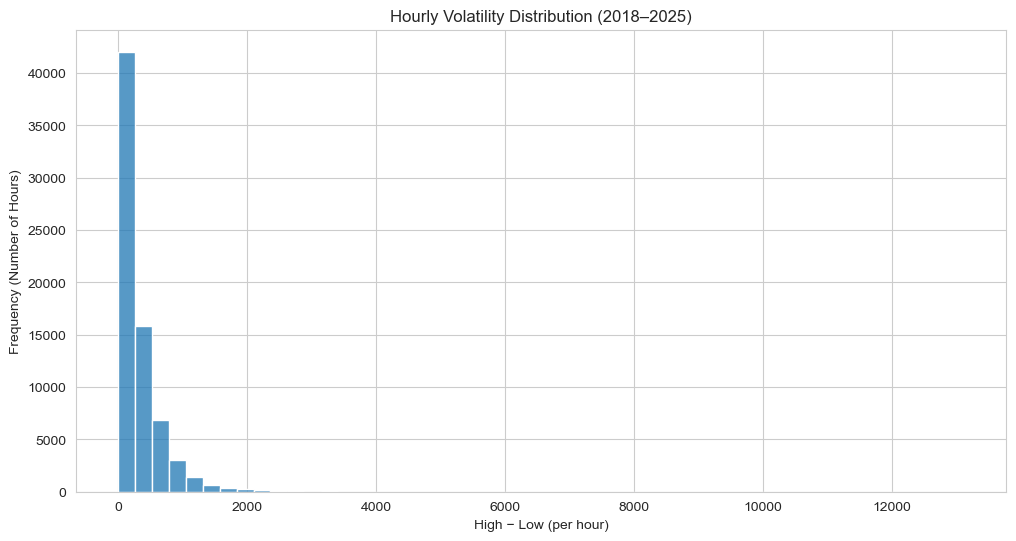

In [49]:
#volatility distribution plot(all years)
sns.histplot(df['price_range'], bins=50)
plt.title("Hourly Volatility Distribution (2018–2025)")
plt.xlabel("High − Low (per hour)")
plt.ylabel("Frequency (Number of Hours)")
plt.show()

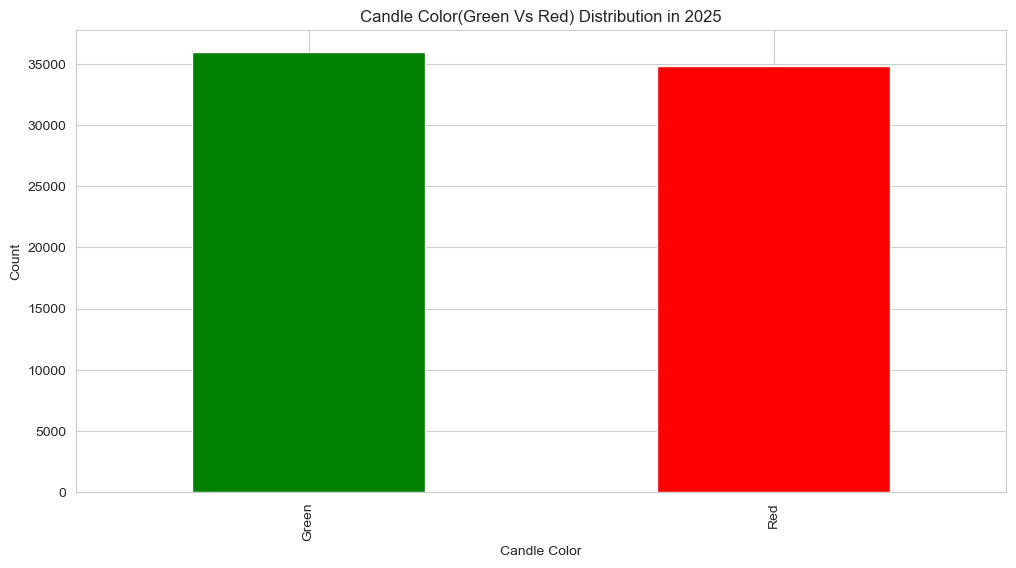

In [50]:
#Trend direction distribution(Green/Red candles)

df['direction'] = np.where(df['Close'] > df['Open'], 'Green', 'Red')
df['direction'].value_counts().plot(kind='bar', color=['green', 'red'])
# counts, bin_edges = np.histogram(df_2025['Candle_Color'].map({'Green(UP)':1, 'Red(DOWN)':0}))
# print(counts)
# print(bin_edges)
plt.title("Candle Color(Green Vs Red) Distribution in 2025")
plt.xlabel("Candle Color")
plt.ylabel("Count")
plt.show()

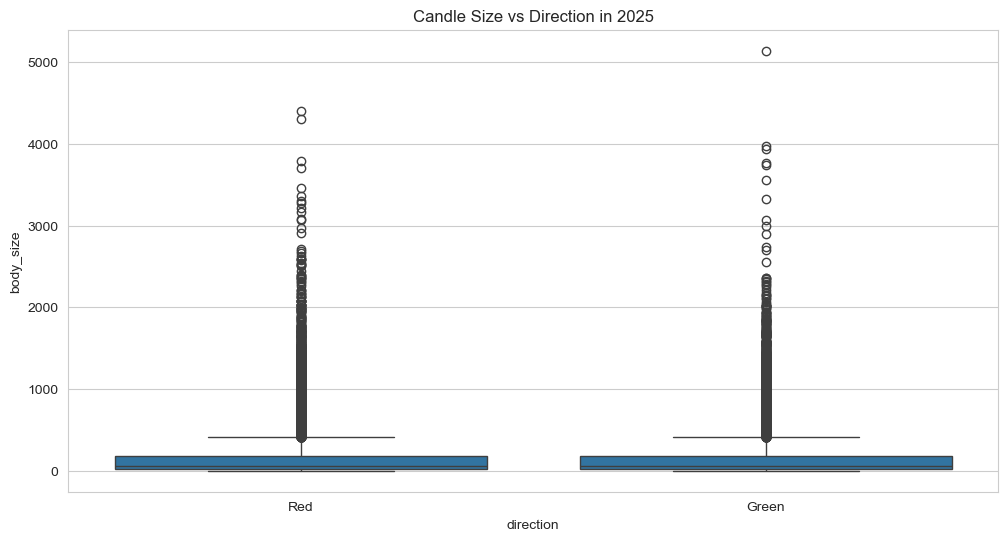

In [51]:
#Feature vs Direction

sns.boxplot(x='direction', y='body_size', data=df)
plt.title("Candle Size vs Direction in 2025")
plt.show()

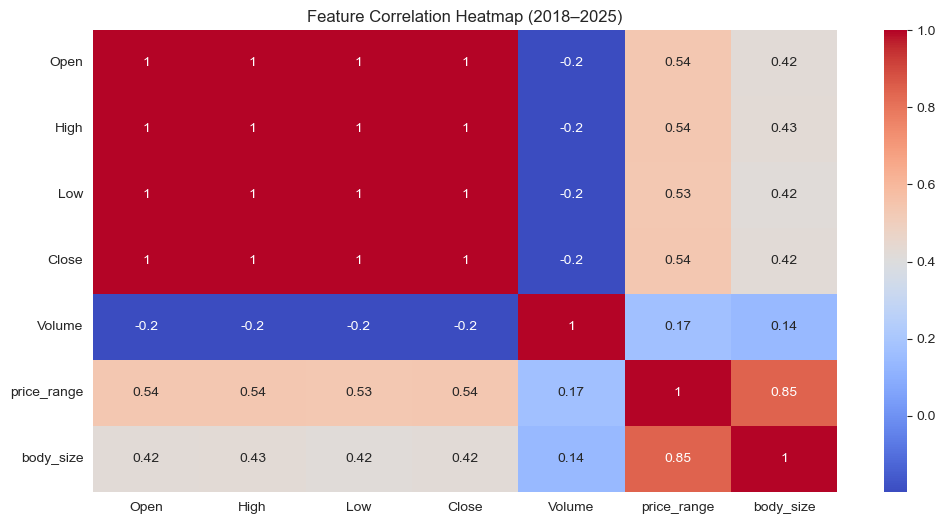

In [52]:
#feature relationship(correlation heatmap)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'price_range', 'body_size']
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap (2018–2025)")
plt.show()

In [53]:
#Feature	Hourly Meaning
#price_range	How much price fluctuated within the hour
#body_size	Strength of movement in that hour
#return	candle + size of that hour
#log_return	Stable version of hourly return

In [54]:
#Feature Selection and Reduction

features = ['price_range','body_size','Volume','return','log_return']
X = df[features]
y = df['direction']

In [55]:
# Gini based feature importance

tree = DecisionTreeClassifier(criterion='gini', random_state=42)
tree.fit(X, y)

importance = pd.Series(
    tree.feature_importances_,
    index=features
).sort_values(ascending=False)

importance

return         1.0
price_range    0.0
body_size      0.0
Volume         0.0
log_return     0.0
dtype: float64

In [56]:
selected_features = importance.index[:5].tolist()
final_df = df[selected_features].copy()
final_df.to_csv("cryptoflow_hourly_features_allyears.csv", index=False)
print(final_df.head())

     return  price_range  body_size      Volume  log_return
0 -0.013608       315.64     186.64  443.356199   -0.013701
1 -0.024091       440.51     325.93  383.697006   -0.024386
2  0.009633       218.43     127.18  429.064572    0.009587
3  0.005984       321.27      79.77  420.087030    0.005966
4  0.012358       301.14     166.03  340.807329    0.012282


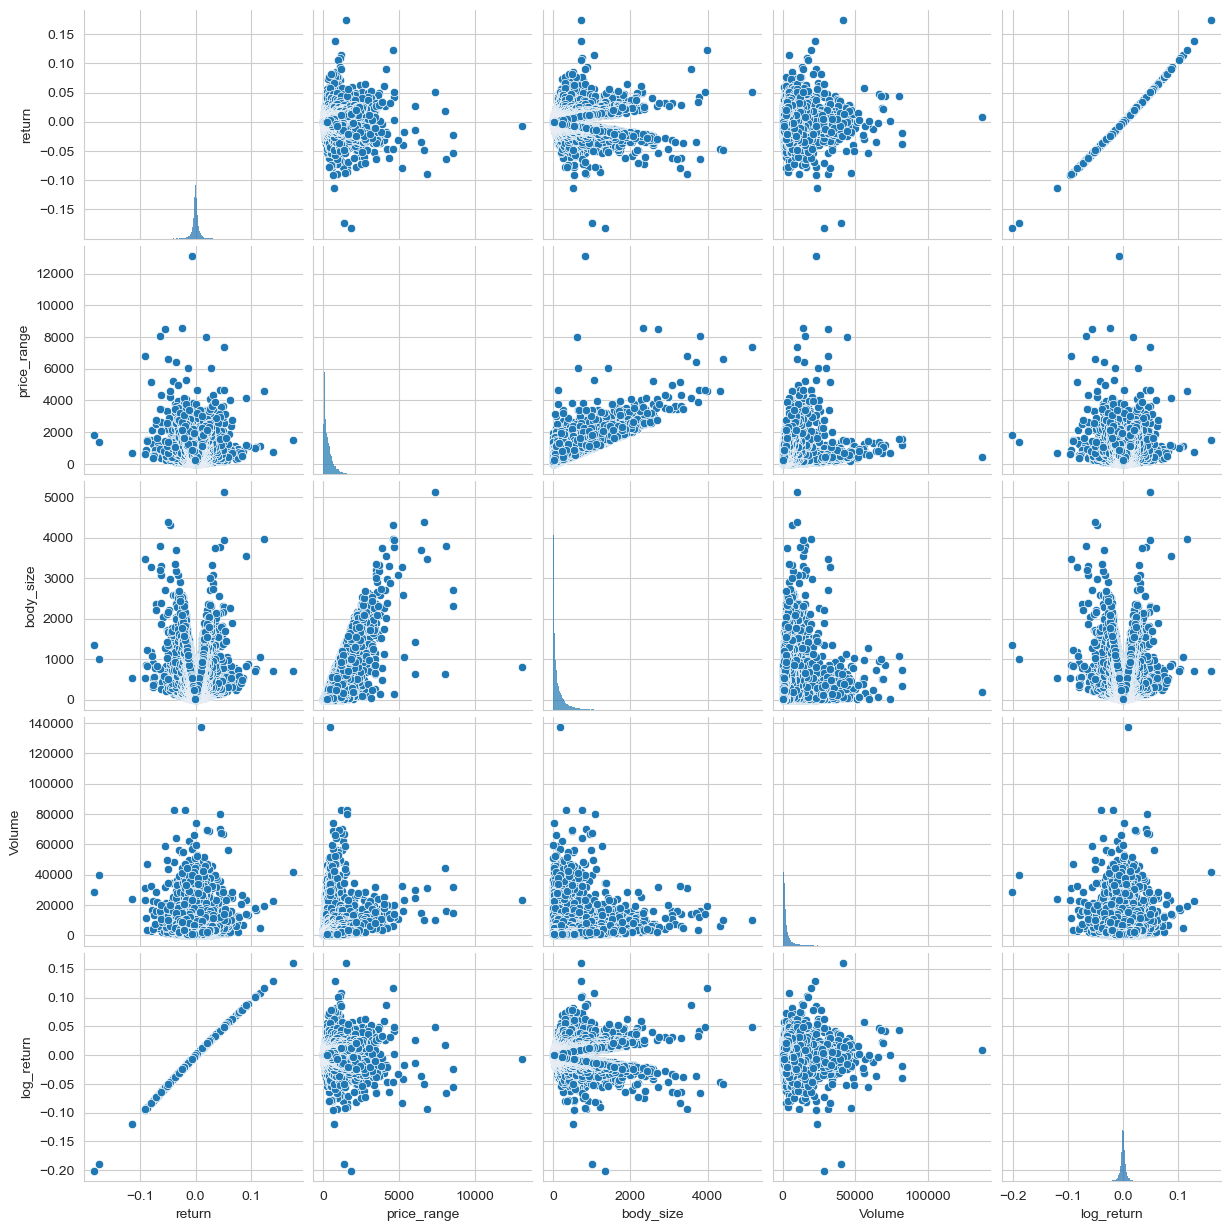

In [57]:
sns.pairplot(final_df)
plt.show()

In [58]:
final_df_with_target = df[selected_features + ['direction']]
final_df_with_target.to_csv(
    "cryptoflow_hourly_features_allyears_with_target.csv",
    index=False
)
print(final_df_with_target.head())

     return  price_range  body_size      Volume  log_return direction
0 -0.013608       315.64     186.64  443.356199   -0.013701       Red
1 -0.024091       440.51     325.93  383.697006   -0.024386       Red
2  0.009633       218.43     127.18  429.064572    0.009587     Green
3  0.005984       321.27      79.77  420.087030    0.005966     Green
4  0.012358       301.14     166.03  340.807329    0.012282     Green
